# CGAN-LSTM para Generación de Señales ECG Sintéticas

Este notebook implementa una **Conditional Generative Adversarial Network (CGAN)** con arquitectura mejorada (ConvTranspose + LSTM) para generar señales ECG sintéticas condicionadas por tipo de arritmia.

## 📋 Estructura del Notebook

1. **Importación de Librerías** → Configuración inicial
2. **Carga y Exploración del Dataset** → Datos ECG de 17 clases
3. **Preparación del Dataset** → ECGDataset personalizado
4. **Arquitectura del Modelo** → ImprovedGenerator e ImprovedDiscriminator
   - 4.1: Generador (ConvTranspose + LSTM + Residual)
   - 4.2: Discriminador (Conv + Instance Norm + LSTM)
   - 4.3: Función de entrenamiento mejorada
5. **Configuración y Entrenamiento** → Hiperparámetros y loop principal
6. **Evaluación y Visualización** → Métricas y comparaciones
7. **Guardado y Carga de Modelos** → Persistencia

## 🎯 Características Clave

- ✅ **Arquitectura Mejorada**: ConvTranspose1D para generación progresiva
- ✅ **Múltiples Losses**: Adversarial + Feature Matching + Frequency Loss
- ✅ **Estabilidad**: Instance Norm, Label Smoothing, Gradient Clipping
- ✅ **Condicionamiento**: Generación controlada por tipo de arritmia
- ✅ **17 Clases**: NSR, APB, AFL, AFIB, SVTA, WPW, PVC, etc.

---

In [1]:
# 1. IMPORTACIÓN DE LIBRERÍAS

import os
import time

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

## 2. Carga y Exploración del Dataset ECG

Cargamos el dataset preprocesado que contiene señales ECG de 17 tipos de arritmias diferentes.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW, Adam

## 3. Preparación del Dataset

Creamos un Dataset personalizado en PyTorch para manejar las señales ECG.

In [3]:
!pwd

/home/hinton2/Documents/proyecto_moises/Tesis-MIA-UNI/notebooks


In [4]:
#!wget https://github.com/MSMRo/Tesis-MIA-UNI/raw/refs/heads/TEST_SIN/notebooks/ECG_DATASET/dataset_ekg.pkl

In [5]:
!ls

 1_generacion_DB.ipynb
 2_1_Feature_Engineering.ipynb
 2_preprocesamiento_DB.ipynb
 3_Procesamiento.ipynb
 4_GAN_1D.ipynb
'5_1_CGAN_LSTM copy.ipynb'
 5_1_CGAN_LSTM.ipynb
 5_1_CGAN_LSTM_ORGANIZADO.ipynb
 5_GEN_SIGNAL_VANILLA.ipynb
 5_GEN_SIGNAL_VANILLA_LSTM.ipynb
 classification_results_summary.csv
 class_mapping.pkl
 comparison_real_vs_synthetic.png
 data.csv
 ECG_DATASET
 ECG_DATASET_V2
 generated_NSR_examples.png
 generated_samples
 models
 _OLD
 RAW_ECG_DATASET
 synthetic_ecg_dataset.pkl
 TESTS
 training_metrics.png
 wavelet_classification_results_summary.csv


In [6]:
import pickle

#path_db = "./dataset_ekg.pkl"

In [7]:


path_db = "./ECG_DATASET/dataset_ekg.pkl"

with open(path_db, "rb") as f:
    dataset = pickle.load(f)

print("Clases disponibles:", dataset.keys())

print("\nForma de cada clase:")    
#print(f"{key}: {value.shape}")
for key, value in dataset.items():
    print(f"{key}: {value.shape}")

Clases disponibles: dict_keys(['NSR', 'VT', 'IVR', 'VFL', 'Fusion', 'LBBBB', 'RBBBB', 'SDHB', 'PR', 'APB', 'AFL', 'AFIB', 'SVTA', 'WPW', 'PVC', 'Bigeminy', 'Trigeminy'])

Forma de cada clase:
NSR: (283, 3600)
VT: (10, 3600)
IVR: (10, 3600)
VFL: (10, 3600)
Fusion: (11, 3600)
LBBBB: (103, 3600)
RBBBB: (62, 3600)
SDHB: (10, 3600)
PR: (45, 3600)
APB: (66, 3600)
AFL: (20, 3600)
AFIB: (135, 3600)
SVTA: (13, 3600)
WPW: (21, 3600)
PVC: (133, 3600)
Bigeminy: (55, 3600)
Trigeminy: (13, 3600)


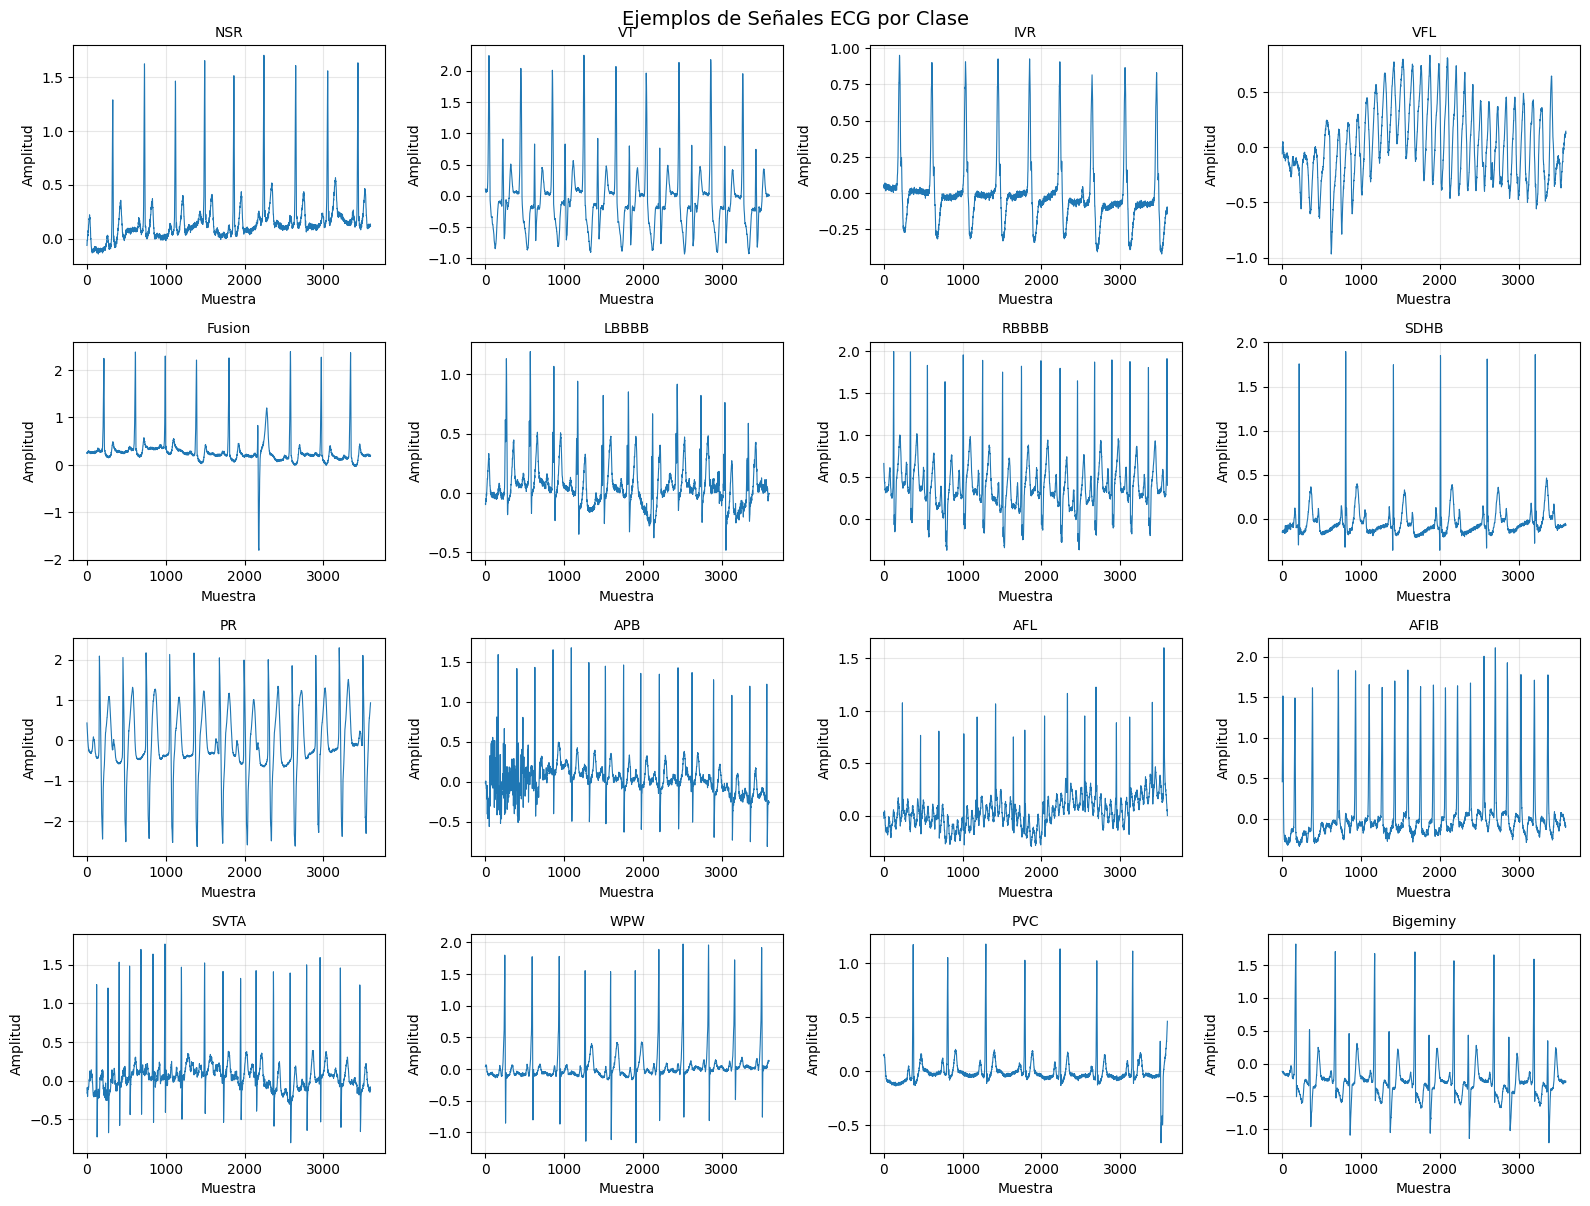

In [8]:
class_names = list(dataset.keys())

# Visualizar algunas señales de ejemplo
fig, axes = plt.subplots(4, 4, figsize=(16, 12))
axes = axes.flatten()

for idx, class_name in enumerate(class_names[:16]):
    signal = dataset[class_name][0]  # Primera señal de cada clase
    axes[idx].plot(signal, linewidth=0.8)
    axes[idx].set_title(f"{class_name}", fontsize=10)
    axes[idx].set_xlabel("Muestra")
    axes[idx].set_ylabel("Amplitud")
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.suptitle("Ejemplos de Señales ECG por Clase", fontsize=14, y=1.001)
plt.show()

### 3.1 Clase ECGDataset

Dataset que normaliza señales a [-1, 1] y retorna tensores con sus etiquetas.

In [9]:
from torch.utils.data import Dataset, DataLoader

class ECGDataset(Dataset):
    """Dataset personalizado para señales ECG"""
    
    def __init__(self, data_dict, class_to_idx, normalize=True):
        """
        Args:
            data_dict: Diccionario {clase: array de señales}
            class_to_idx: Diccionario {nombre_clase: índice}
            normalize: Si True, normaliza las señales a [-1, 1]
        """
        self.signals = []
        self.labels = []
        
        for class_name, signals in data_dict.items():
            class_idx = class_to_idx[class_name]
            for signal in signals:
                self.signals.append(signal)
                self.labels.append(class_idx)
        
        self.signals = np.array(self.signals, dtype=np.float32)
        self.labels = np.array(self.labels, dtype=np.int64)
        
        # Normalización opcional
        if normalize:
            # Normalizar cada señal independientemente a [-1, 1]
            for i in range(len(self.signals)):
                min_val = self.signals[i].min()
                max_val = self.signals[i].max()
                if max_val > min_val:
                    self.signals[i] = 2 * (self.signals[i] - min_val) / (max_val - min_val) - 1
        
        print(f"Dataset creado: {len(self.signals)} señales, {len(np.unique(self.labels))} clases")
    
    def __len__(self):
        return len(self.signals)
    
    def __getitem__(self, idx):
        signal = torch.FloatTensor(self.signals[idx]).unsqueeze(0)  # (1, seq_len)
        label = torch.LongTensor([self.labels[idx]])
        return signal, label

# Crear mapeo de clase a índice
class_to_idx = {name: idx for idx, name in enumerate(class_names)}

# Crear dataset
ecg_dataset = ECGDataset(dataset, class_to_idx, normalize=True)

# Crear DataLoader
batch_size = 64
dataloader = DataLoader(ecg_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

print(f"Batch size: {batch_size}")
print(f"Número de batches: {len(dataloader)}")

Dataset creado: 1000 señales, 17 clases
Batch size: 64
Número de batches: 15


## 4. Arquitectura del Modelo CGAN-LSTM

### 4.1 Generador Mejorado (ConvTranspose + LSTM + Residual)

Generador mejorado que usa convoluciones transpuestas para generación progresiva,
LSTM para coherencia temporal y conexiones residuales.

In [10]:
# NOTA: Esta celda contiene la arquitectura básica LSTM (referencia histórica)
# Para entrenamiento, usar ImprovedGenerator definido más abajo

import torch.nn as nn

class LSTMGenerator(nn.Module):
    """Generador basado en LSTM (versión básica - NO USAR para entrenamiento)"""
    
    def __init__(self, latent_dim, num_classes, seq_length, embedding_dim=50, 
                 hidden_dim=256, num_layers=2, dropout=0.3):
        """
        Args:
            latent_dim: Dimensión del vector de ruido
            num_classes: Número de clases (tipos de arritmia)
            seq_length: Longitud de la señal a generar
            embedding_dim: Dimensión del embedding de clase
            hidden_dim: Dimensión oculta del LSTM
            num_layers: Número de capas LSTM
            dropout: Tasa de dropout
        """
        super(LSTMGenerator, self).__init__()
        
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.seq_length = seq_length
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Embedding para las clases
        self.label_embedding = nn.Embedding(num_classes, embedding_dim)
        
        # Capa de entrada: combina ruido + embedding de clase
        self.input_dim = latent_dim + embedding_dim
        
        # Proyección inicial
        self.fc_input = nn.Sequential(
            nn.Linear(self.input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim)
        )
        
        # LSTM multi-capa
        self.lstm = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Capa de salida: genera la señal
        self.fc_output = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Tanh()  # Salida en [-1, 1]
        )
    
    def forward(self, noise, labels):
        """
        Args:
            noise: (batch_size, latent_dim)
            labels: (batch_size, 1)
        Returns:
            generated_signals: (batch_size, 1, seq_length)
        """
        batch_size = noise.size(0)
        
        # Embedding de las etiquetas
        label_emb = self.label_embedding(labels.squeeze(1))  # (batch_size, embedding_dim)
        
        # Concatenar ruido + embedding
        gen_input = torch.cat([noise, label_emb], dim=1)  # (batch_size, latent_dim + embedding_dim)
        
        # Proyección inicial
        x = self.fc_input(gen_input)  # (batch_size, hidden_dim)
        
        # Expandir para LSTM: repetir hidden_dim a lo largo de seq_length
        x = x.unsqueeze(1).repeat(1, self.seq_length, 1)  # (batch_size, seq_length, hidden_dim)
        
        # LSTM
        lstm_out, _ = self.lstm(x)  # (batch_size, seq_length, hidden_dim)
        
        # Generar señal punto por punto
        output = self.fc_output(lstm_out)  # (batch_size, seq_length, 1)
        
        # Transponer a formato (batch_size, 1, seq_length)
        output = output.transpose(1, 2)
        

        return output
    
print("✓ Generador LSTM definido")


✓ Generador LSTM definido


### 4.1 🎯 Arquitectura Mejorada (USAR ESTA)

**Por qué esta arquitectura es mejor:**
1. ❌ Solo usa FC + LSTM → difícil generar señales largas (3600 muestras)
2. ❌ Repite el mismo vector 3600 veces → no hay variabilidad temporal
3. ❌ BatchNorm en discriminador → inestabilidad en GANs
4. ❌ Sin pérdidas auxiliares → solo adversarial loss

**Mejoras aplicadas:**
1. ✅ ConvTranspose1D → genera señales progresivamente
2. ✅ Instance Normalization → más estable que BatchNorm
3. ✅ Residual connections → mejor flujo de gradientes
4. ✅ Feature matching + frequency loss → señales más realistas

In [11]:
class ImprovedGenerator(nn.Module):
    """Generador mejorado: ConvTranspose + LSTM + Residual"""
    
    def __init__(self, latent_dim, num_classes, seq_length, embedding_dim=50):
        super().__init__()
        self.latent_dim = latent_dim
        self.seq_length = seq_length
        
        # Embedding de clase
        self.label_embedding = nn.Embedding(num_classes, embedding_dim)
        input_dim = latent_dim + embedding_dim
        
        # Proyección inicial a un tensor pequeño
        self.fc_project = nn.Sequential(
            nn.Linear(input_dim, 256 * 14),
            nn.LeakyReLU(0.2)
        )
        
        # ConvTranspose1D progresivas (14 -> 56 -> 224 -> 896 -> 3584)
        self.deconv1 = nn.ConvTranspose1d(256, 128, kernel_size=25, stride=4, padding=11)
        self.deconv2 = nn.ConvTranspose1d(128, 64, kernel_size=25, stride=4, padding=11)
        self.deconv3 = nn.ConvTranspose1d(64, 32, kernel_size=25, stride=4, padding=11)
        self.deconv4 = nn.ConvTranspose1d(32, 16, kernel_size=25, stride=4, padding=11)
        
        # Batch Normalization
        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(32)
        self.bn4 = nn.BatchNorm1d(16)
        
        # LSTM para suavizado y coherencia temporal
        self.lstm = nn.LSTM(16, 32, num_layers=2, batch_first=True, bidirectional=True)
        
        # Capas finales con residual
        self.conv_res1 = nn.Conv1d(64, 32, kernel_size=1)
        self.conv_res2 = nn.Conv1d(32, 16, kernel_size=1)
        self.conv_out = nn.Conv1d(16, 1, kernel_size=1)
        
    def forward(self, noise, labels):
        batch_size = noise.size(0)
        
        # Embedding + concatenar
        label_emb = self.label_embedding(labels.squeeze(1))
        x = torch.cat([noise, label_emb], dim=1)
        
        # Proyección
        x = self.fc_project(x).view(batch_size, 256, 14)
        
        # Deconvoluciones progresivas
        x = F.leaky_relu(self.bn1(self.deconv1(x)), 0.2)
        x = F.leaky_relu(self.bn2(self.deconv2(x)), 0.2)
        x = F.leaky_relu(self.bn3(self.deconv3(x)), 0.2)
        x = F.leaky_relu(self.bn4(self.deconv4(x)), 0.2)
        
        # LSTM para coherencia temporal
        x_temp = x.transpose(1, 2)
        x_temp, _ = self.lstm(x_temp)
        x_lstm = x_temp.transpose(1, 2)
        
        # Residual connections (ajustar dimensiones)
        x_res = self.conv_res1(x_lstm)  # 64 -> 32
        x_res = F.leaky_relu(x_res, 0.2)
        x_res = self.conv_res2(x_res)  # 32 -> 16
        
        # Sumar con x (ambos tienen 16 canales ahora)
        x = x + x_res[:, :, :x.size(2)]
        x = F.leaky_relu(x, 0.2)
        x = torch.tanh(self.conv_out(x))
        
        # Ajustar a longitud exacta
        x = F.interpolate(x, size=self.seq_length, mode='linear', align_corners=False)
        
        return x

print("✓ Generador mejorado definido")

✓ Generador mejorado definido


In [12]:
class ImprovedDiscriminator(nn.Module):
    """Discriminador mejorado: Conv1D + Instance Norm + LSTM"""
    
    def __init__(self, num_classes, seq_length, embedding_dim=50):
        super().__init__()
        
        # Embedding de clase
        self.label_embedding = nn.Embedding(num_classes, embedding_dim)
        self.label_proj = nn.Linear(embedding_dim, seq_length)
        
        # Convoluciones para extracción de características
        self.conv1 = nn.Conv1d(2, 32, kernel_size=25, stride=4, padding=12)  # 2 canales: señal + label
        self.conv2 = nn.Conv1d(32, 64, kernel_size=25, stride=4, padding=12)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=25, stride=4, padding=12)
        self.conv4 = nn.Conv1d(128, 256, kernel_size=25, stride=4, padding=12)
        
        # Instance Norm (mejor que Batch Norm para GANs)
        self.in1 = nn.InstanceNorm1d(32)
        self.in2 = nn.InstanceNorm1d(64)
        self.in3 = nn.InstanceNorm1d(128)
        self.in4 = nn.InstanceNorm1d(256)
        
        # LSTM bidireccional
        self.lstm = nn.LSTM(256, 128, num_layers=2, batch_first=True, 
                           bidirectional=True, dropout=0.3)
        
        # Capas finales
        self.fc = nn.Sequential(
            nn.Linear(256, 128),  # 128*2 del LSTM bidireccional
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
        
    def forward(self, signal, labels):
        # Embedding + proyección
        label_emb = self.label_embedding(labels.squeeze(1))
        label_proj = self.label_proj(label_emb).unsqueeze(1)
        
        # Concatenar señal + label
        x = torch.cat([signal, label_proj], dim=1)
        
        # Convoluciones
        x = F.leaky_relu(self.in1(self.conv1(x)), 0.2)
        x = F.leaky_relu(self.in2(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.in3(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.in4(self.conv4(x)), 0.2)
        
        # LSTM
        x = x.transpose(1, 2)
        lstm_out, (h_n, _) = self.lstm(x)
        
        # Último estado oculto (forward + backward)
        last_hidden = torch.cat([h_n[-2], h_n[-1]], dim=1)
        
        # Clasificación
        validity = self.fc(last_hidden)
        
        return validity

print("✓ Discriminador mejorado definido")

✓ Discriminador mejorado definido


In [13]:
# 4.3 Función de Entrenamiento Mejorada

def improved_train_epoch(generator, discriminator, dataloader, optimizer_G, optimizer_D, 
                        adversarial_loss, device, epoch, latent_dim, num_classes):
    """Entrenamiento mejorado con feature matching y frequency loss"""
    generator.train()
    discriminator.train()
    
    epoch_g_loss = 0.0
    epoch_d_loss = 0.0
    epoch_d_real_acc = 0.0
    epoch_d_fake_acc = 0.0
    
    # Label smoothing (buena práctica)
    real_label = 0.9
    fake_label = 0.1
    
    for i, (real_signals, labels) in enumerate(dataloader):
        batch_size = real_signals.size(0)
        real_signals = real_signals.to(device)
        labels = labels.to(device)
        
        # Etiquetas suaves
        valid = torch.full((batch_size, 1), real_label, device=device)
        fake_labels_d = torch.full((batch_size, 1), fake_label, device=device)
        
        # =======================
        #  Entrenar Discriminador
        # =======================
        optimizer_D.zero_grad()
        
        # Real
        real_pred = discriminator(real_signals, labels)
        d_real_loss = adversarial_loss(real_pred, valid)
        
        # Fake
        z = torch.randn(batch_size, latent_dim, device=device)
        gen_labels = torch.randint(0, num_classes, (batch_size, 1), device=device)
        gen_signals = generator(z, gen_labels)
        fake_pred = discriminator(gen_signals.detach(), gen_labels)
        d_fake_loss = adversarial_loss(fake_pred, fake_labels_d)
        
        # Loss total
        d_loss = (d_real_loss + d_fake_loss) / 2
        d_loss.backward()
        
        # Gradient clipping para estabilidad
        torch.nn.utils.clip_grad_norm_(discriminator.parameters(), max_norm=1.0)
        optimizer_D.step()
        
        # ==================
        #  Entrenar Generador (2 veces por cada D)
        # ==================
        for _ in range(2):
            optimizer_G.zero_grad()
            
            z = torch.randn(batch_size, latent_dim, device=device)
            gen_labels = torch.randint(0, num_classes, (batch_size, 1), device=device)
            gen_signals = generator(z, gen_labels)
            
            # Adversarial loss
            validity = discriminator(gen_signals, gen_labels)
            g_adv_loss = adversarial_loss(validity, torch.ones((batch_size, 1), device=device))
            
            # Feature matching loss (comparar estadísticas)
            real_mean = real_signals.mean(dim=2, keepdim=True)
            real_std = real_signals.std(dim=2, keepdim=True)
            fake_mean = gen_signals.mean(dim=2, keepdim=True)
            fake_std = gen_signals.std(dim=2, keepdim=True)
            
            feature_loss = F.mse_loss(fake_mean, real_mean) + F.mse_loss(fake_std, real_std)
            
            # Frequency loss (dominio de frecuencia)
            real_fft = torch.fft.rfft(real_signals, dim=2)
            fake_fft = torch.fft.rfft(gen_signals, dim=2)
            freq_loss = F.l1_loss(torch.abs(fake_fft), torch.abs(real_fft))
            
            # Loss combinado
            g_loss = g_adv_loss + 0.1 * feature_loss + 0.05 * freq_loss
            
            g_loss.backward()
            torch.nn.utils.clip_grad_norm_(generator.parameters(), max_norm=1.0)
            optimizer_G.step()
        
        # Métricas
        epoch_g_loss += g_loss.item()
        epoch_d_loss += d_loss.item()
        epoch_d_real_acc += (real_pred > 0.5).float().mean().item()
        epoch_d_fake_acc += (fake_pred < 0.5).float().mean().item()
    
    num_batches = len(dataloader)
    return {
        'g_loss': epoch_g_loss / num_batches,
        'd_loss': epoch_d_loss / num_batches,
        'd_real_acc': epoch_d_real_acc / num_batches,
        'd_fake_acc': epoch_d_fake_acc / num_batches
    }

print("✓ Función de entrenamiento mejorada definida")

✓ Función de entrenamiento mejorada definida


## 5. Configuración y Entrenamiento

### 5.1 Hiperparámetros y Configuración

In [17]:
# Configuración del dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Dispositivo: {device}")

# Hiperparámetros
latent_dim = 100
num_classes = len(class_names)
seq_length = 3600
embedding_dim = 50

lr_g = 0.0001
lr_d = 0.0001
num_epochs = 50
sample_interval = 100

# Mapeos de clases
idx_to_class = {idx: name for name, idx in class_to_idx.items()}
adversarial_loss = nn.BCELoss()

print(f"\nHiperparámetros:")
print(f"  Latent dim: {latent_dim}")
print(f"  Clases: {num_classes}")
print(f"  Seq length: {seq_length}")

print(f"  LR G/D: {lr_g} / {lr_d}")
print(f"  Épocas: {num_epochs}")

Dispositivo: cuda

Hiperparámetros:
  Latent dim: 100
  Clases: 17
  Seq length: 3600
  LR G/D: 0.0001 / 0.0001
  Épocas: 50


In [18]:
# Crear modelos mejorados
print("="*80)
print("CREANDO MODELOS CGAN-LSTM")
print("="*80)

generator = ImprovedGenerator(
    latent_dim=latent_dim,
    num_classes=num_classes,
    seq_length=seq_length,
    embedding_dim=embedding_dim
).to(device)

discriminator = ImprovedDiscriminator(
    num_classes=num_classes,
    seq_length=seq_length,
    embedding_dim=embedding_dim
).to(device)

print(f"\nGenerador:")
print(f"  Parámetros: {sum(p.numel() for p in generator.parameters()):,}")
print(f"\nDiscriminador:")
print(f"  Parámetros: {sum(p.numel() for p in discriminator.parameters()):,}")

# Optimizadores
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr_g, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.999))

# Schedulers
scheduler_G = torch.optim.lr_scheduler.StepLR(optimizer_G, step_size=500, gamma=0.95)
scheduler_D = torch.optim.lr_scheduler.StepLR(optimizer_D, step_size=500, gamma=0.95)

print(f"\nOptimizadores configurados:")
print(f"  LR: {lr_g}")
print(f"  Betas: (0.5, 0.999)")
print(f"  Scheduler: StepLR (cada 500 epochs, gamma=0.95)")
print("\n✓ Modelos inicializados")

CREANDO MODELOS CGAN-LSTM

Generador:
  Parámetros: 1,671,267

Discriminador:
  Parámetros: 2,085,283

Optimizadores configurados:
  LR: 0.0001
  Betas: (0.5, 0.999)
  Scheduler: StepLR (cada 500 epochs, gamma=0.95)

✓ Modelos inicializados


In [19]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import os
import time

# Función auxiliar para generar y visualizar señales
def generate_and_plot_signals(generator, num_classes, idx_to_class, latent_dim,
                              seq_length, device, epoch, save_dir='generated_samples'):
    """Genera y visualiza señales sintéticas durante el entrenamiento"""
    os.makedirs(save_dir, exist_ok=True)
    
    generator.eval()
    
    fig, axes = plt.subplots(4, 4, figsize=(16, 12))
    axes = axes.flatten()
    
    with torch.no_grad():
        for idx in range(min(16, num_classes)):
            # Generar señal para esta clase
            z = torch.randn(1, latent_dim, device=device)
            label = torch.LongTensor([[idx]]).to(device)
            gen_signal = generator(z, label).cpu().numpy().squeeze()
            
            # Visualizar
            axes[idx].plot(gen_signal, linewidth=0.8)
            axes[idx].set_title(f"{idx_to_class[idx]}", fontsize=10)
            axes[idx].set_xlabel("Muestra")
            axes[idx].set_ylabel("Amplitud")
            axes[idx].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle(f"Señales Generadas - Época {epoch}", fontsize=14, y=1.001)
    plt.savefig(f'{save_dir}/epoch_{epoch:04d}.png', dpi=100, bbox_inches='tight')
    plt.close()
    
    generator.train()

# Loop de entrenamiento
history = {
    'g_loss': [],
    'd_loss': [],
    'd_real_acc': [],
    'd_fake_acc': []
}

print("Iniciando entrenamiento...\n")
print("="*80)

start_time = time.time()

for epoch in range(num_epochs):
    epoch_start = time.time()
    
    # Entrenar
    metrics = improved_train_epoch(
        generator, discriminator, dataloader,
        optimizer_G, optimizer_D, adversarial_loss,
        device, epoch, latent_dim, num_classes
    )
    
    # Guardar métricas
    history['g_loss'].append(metrics['g_loss'])
    history['d_loss'].append(metrics['d_loss'])
    history['d_real_acc'].append(metrics['d_real_acc'])
    history['d_fake_acc'].append(metrics['d_fake_acc'])
    
    # Update learning rates
    scheduler_G.step()
    scheduler_D.step()
    
    epoch_time = time.time() - epoch_start
    
    # Imprimir progreso cada 50 épocas
    if (epoch + 1) % 50 == 0 or epoch == 0:
        lr_g = optimizer_G.param_groups[0]['lr']
        print(f"Epoch [{epoch+1:4d}/{num_epochs}] | "
              f"G: {metrics['g_loss']:.4f} | "
              f"D: {metrics['d_loss']:.4f} | "
              f"D_real: {metrics['d_real_acc']:.3f} | "
              f"D_fake: {metrics['d_fake_acc']:.3f} | "
              f"LR: {lr_g:.6f} | "
              f"{epoch_time:.2f}s")
    
    # Generar muestras
    if (epoch + 1) % sample_interval == 0:
        generate_and_plot_signals(
            generator, num_classes, idx_to_class, latent_dim,
            seq_length, device, epoch + 1, save_dir='generated_samples'
        )

total_time = time.time() - start_time
print("\n" + "="*80)
print(f"Entrenamiento completado en {total_time/60:.2f} minutos")
print("="*80)

Iniciando entrenamiento...

Epoch [   1/50] | G: 1.0927 | D: 0.6692 | D_real: 0.803 | D_fake: 0.554 | LR: 0.000100 | 2.19s
Epoch [   1/50] | G: 1.0927 | D: 0.6692 | D_real: 0.803 | D_fake: 0.554 | LR: 0.000100 | 2.19s
Epoch [  50/50] | G: 2.6941 | D: 0.4135 | D_real: 0.932 | D_fake: 0.912 | LR: 0.000100 | 2.20s

Entrenamiento completado en 1.83 minutos
Epoch [  50/50] | G: 2.6941 | D: 0.4135 | D_real: 0.932 | D_fake: 0.912 | LR: 0.000100 | 2.20s

Entrenamiento completado en 1.83 minutos


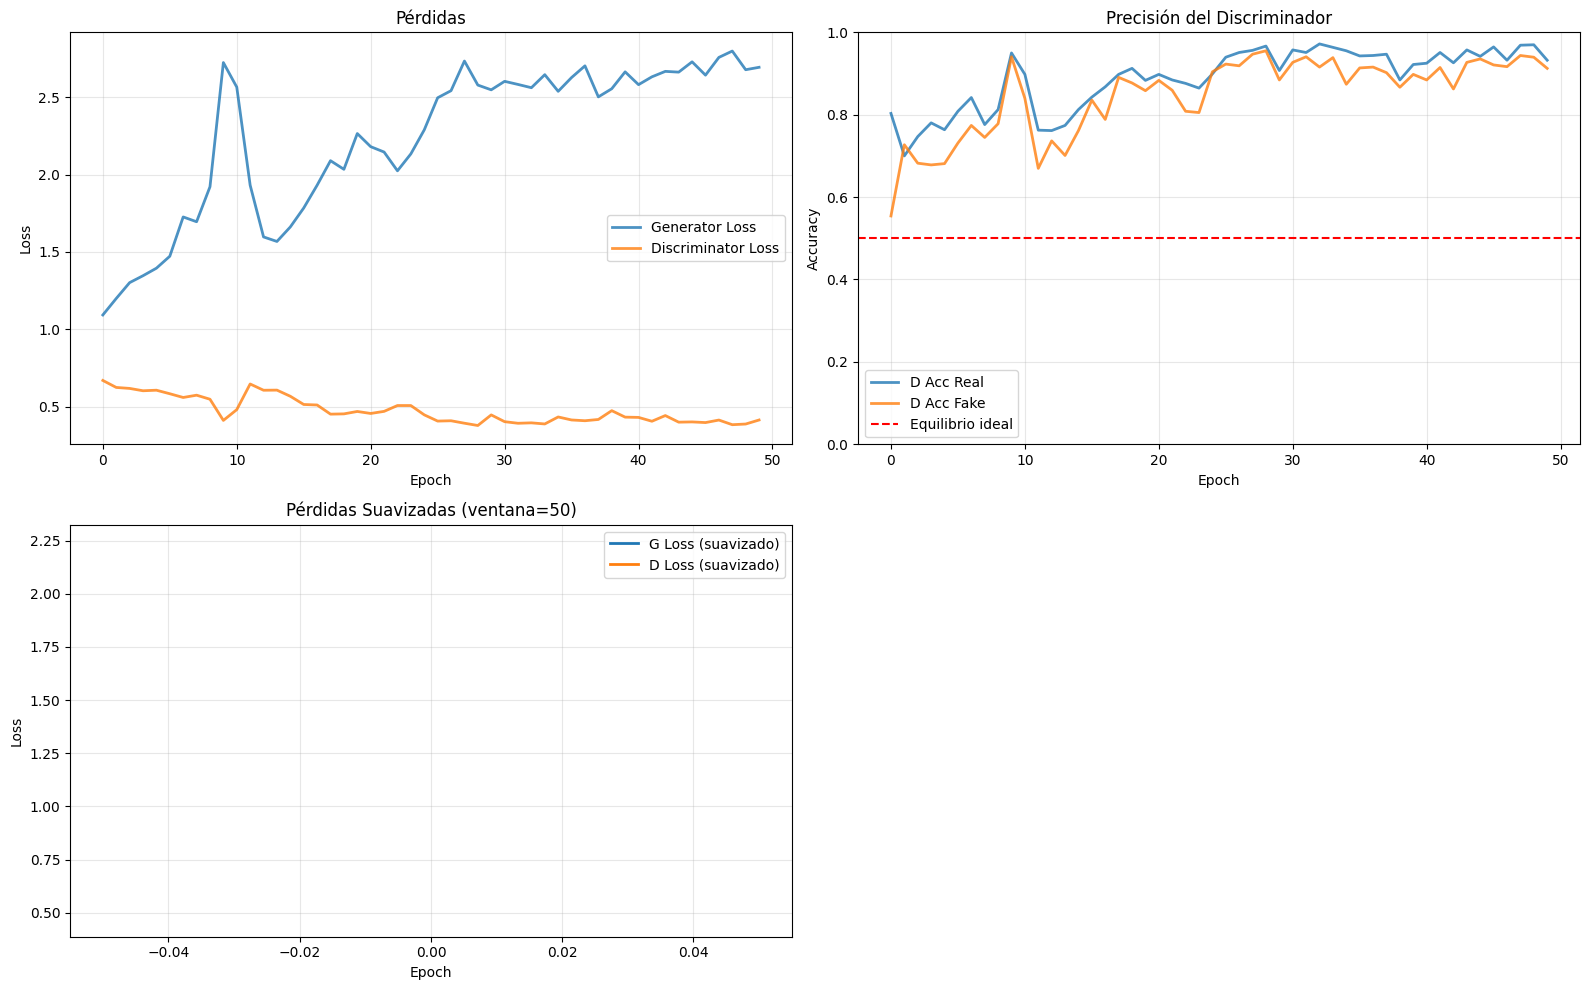

✓ Métricas mejoradas visualizadas


In [20]:
## 6. Evaluación y Visualización

# Visualizar métricas de entrenamiento
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Pérdidas
axes[0, 0].plot(history['g_loss'], label='Generator Loss', linewidth=2, alpha=0.8)
axes[0, 0].plot(history['d_loss'], label='Discriminator Loss', linewidth=2, alpha=0.8)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Pérdidas')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Precisiones
axes[0, 1].plot(history['d_real_acc'], label='D Acc Real', linewidth=2, alpha=0.8)
axes[0, 1].plot(history['d_fake_acc'], label='D Acc Fake', linewidth=2, alpha=0.8)
axes[0, 1].axhline(y=0.5, color='r', linestyle='--', label='Equilibrio ideal')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('Precisión del Discriminador')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)
axes[0, 1].set_ylim(0, 1)

# Loss suavizado (moving average)
window = 50
if len(history['g_loss']) >= window:
    g_smooth = np.convolve(history['g_loss'], np.ones(window)/window, mode='valid')
    d_smooth = np.convolve(history['d_loss'], np.ones(window)/window, mode='valid')
    
    axes[1, 0].plot(g_smooth, label='G Loss (suavizado)', linewidth=2)
    axes[1, 0].plot(d_smooth, label='D Loss (suavizado)', linewidth=2)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].set_title(f'Pérdidas Suavizadas (ventana={window})')
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3)

# Ocultar subplot extra
axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig('training_metrics_improved.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Métricas mejoradas visualizadas")

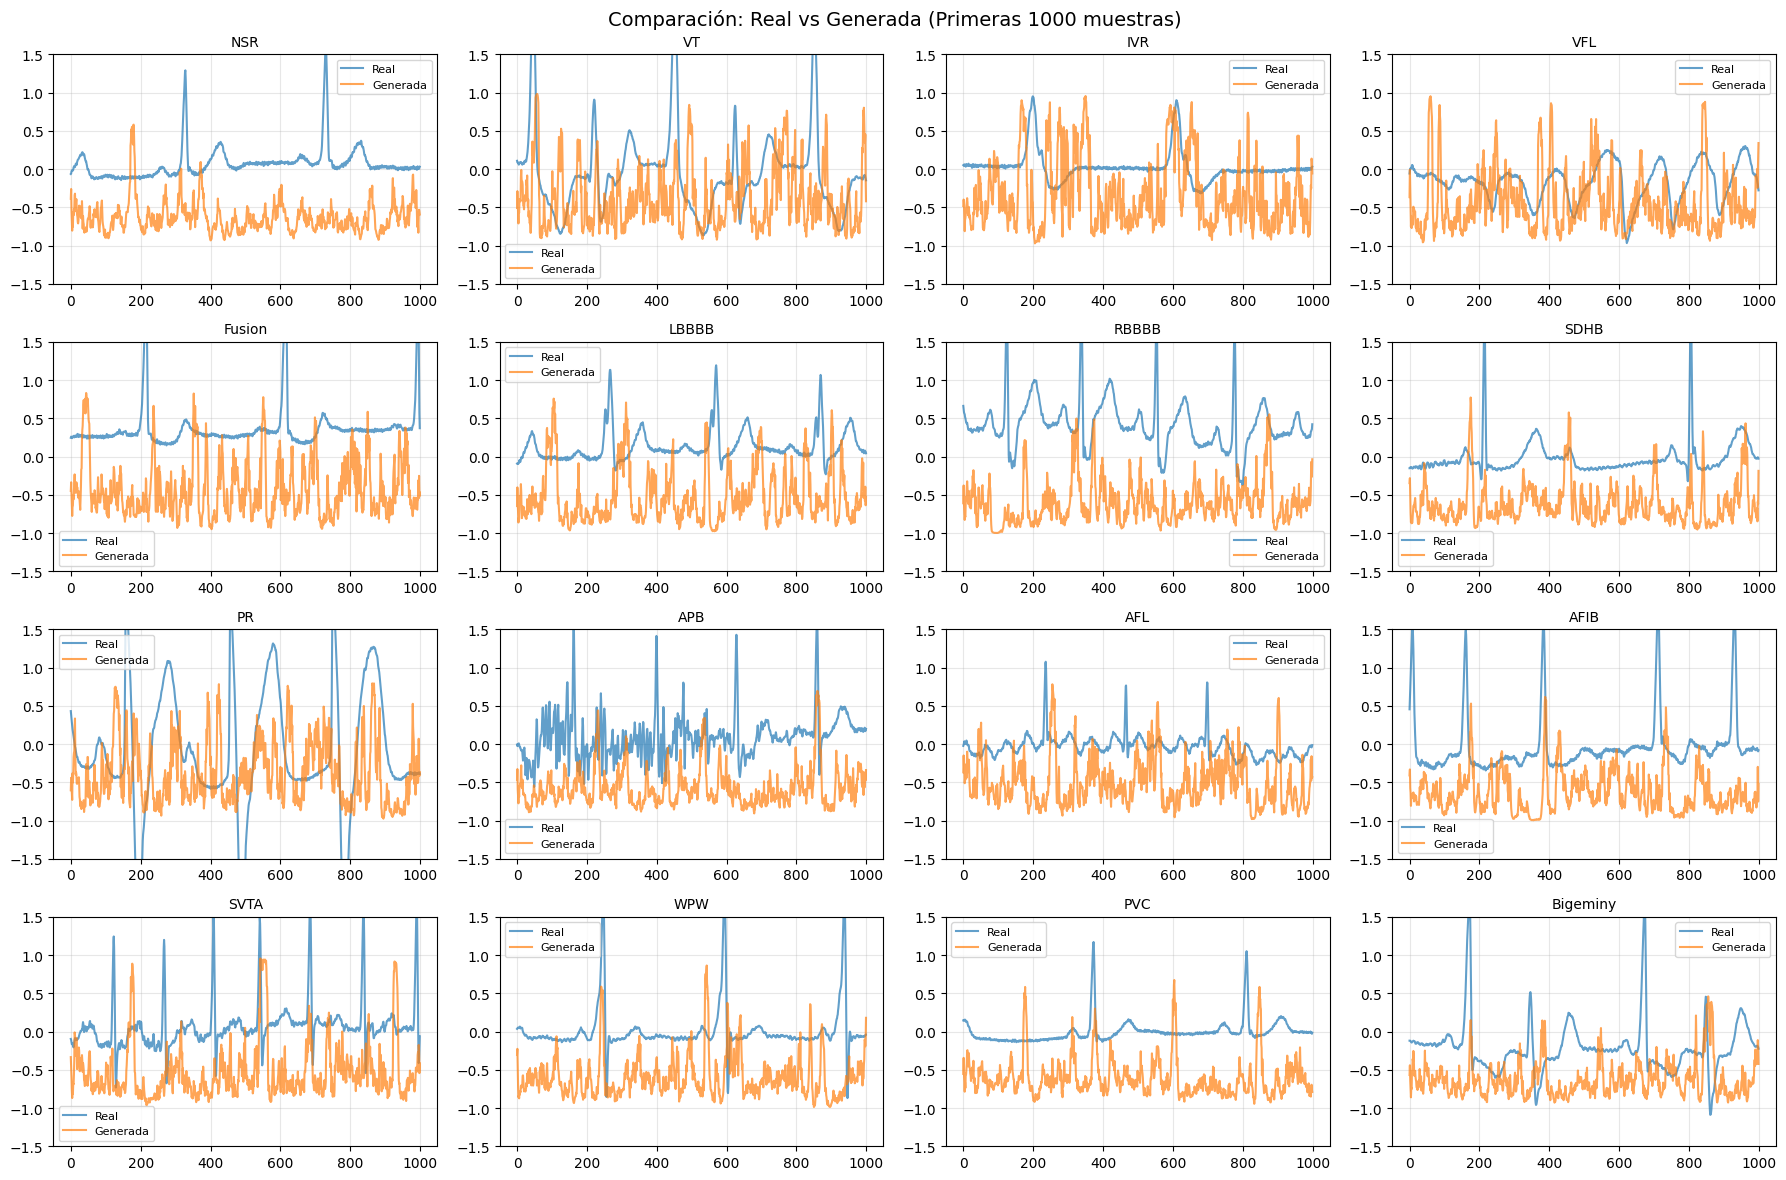

✓ Comparación completada


In [21]:
## 7. Comparación Visual: Real vs Generado

# Comparar señales generadas vs reales
generator.eval()

fig, axes = plt.subplots(4, 4, figsize=(18, 12))
axes = axes.flatten()

with torch.no_grad():
    for idx, class_name in enumerate(class_names[:16]):
        class_idx = class_to_idx[class_name]
        
        # Señal real
        real_signal = dataset[class_name][0]
        
        # Señal generada
        z = torch.randn(1, latent_dim, device=device)
        label = torch.LongTensor([[class_idx]]).to(device)
        gen_signal = generator(z, label).cpu().numpy().squeeze()
        
        # Plot
        axes[idx].plot(real_signal[:1000], label='Real', linewidth=1.5, alpha=0.7)
        axes[idx].plot(gen_signal[:1000], label='Generada', linewidth=1.5, alpha=0.7)
        axes[idx].set_title(f"{class_name}", fontsize=10)
        axes[idx].set_ylim(-1.5, 1.5)
        axes[idx].grid(alpha=0.3)
        axes[idx].legend(fontsize=8)

plt.suptitle("Comparación: Real vs Generada (Primeras 1000 muestras)", fontsize=14)
plt.tight_layout()
plt.savefig('comparison_real_vs_generated.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Comparación completada")

### 4.2 Discriminador Mejorado

Discriminador con Conv1D, Instance Normalization y LSTM bidireccional.

In [22]:
class LSTMDiscriminator(nn.Module):
    """Discriminador basado en LSTM para señales ECG"""
    
    def __init__(self, num_classes, seq_length, embedding_dim=50, 
                 hidden_dim=256, num_layers=2, dropout=0.3):
        """
        Args:
            num_classes: Número de clases
            seq_length: Longitud de la señal
            embedding_dim: Dimensión del embedding de clase
            hidden_dim: Dimensión oculta del LSTM
            num_layers: Número de capas LSTM
            dropout: Tasa de dropout
        """
        super(LSTMDiscriminator, self).__init__()
        
        self.num_classes = num_classes
        self.seq_length = seq_length
        self.hidden_dim = hidden_dim
        
        # Embedding para las clases
        self.label_embedding = nn.Embedding(num_classes, embedding_dim)
        
        # Proyección del embedding a la longitud de la señal
        self.label_proj = nn.Linear(embedding_dim, seq_length)
        
        # LSTM multi-capa (input: señal + embedding proyectado)
        self.lstm = nn.LSTM(
            input_size=2,  # 1 canal señal + 1 canal embedding
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True  # LSTM bidireccional para mejor contexto
        )
        
        # Capas de clasificación
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, 256),  # *2 por bidireccional
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout),
            nn.Linear(128, 1),
            nn.Sigmoid()  # Probabilidad [0, 1]
        )
    
    def forward(self, signal, labels):
        """
        Args:
            signal: (batch_size, 1, seq_length)
            labels: (batch_size, 1)
        Returns:
            validity: (batch_size, 1) - probabilidad de ser real
        """
        batch_size = signal.size(0)
        
        # Embedding de las etiquetas
        label_emb = self.label_embedding(labels.squeeze(1))  # (batch_size, embedding_dim)
        
        # Proyectar embedding a longitud de señal
        label_proj = self.label_proj(label_emb)  # (batch_size, seq_length)
        label_proj = label_proj.unsqueeze(1)  # (batch_size, 1, seq_length)
        
        # Concatenar señal + embedding proyectado
        disc_input = torch.cat([signal, label_proj], dim=1)  # (batch_size, 2, seq_length)
        disc_input = disc_input.transpose(1, 2)  # (batch_size, seq_length, 2)
        
        # LSTM
        lstm_out, (h_n, c_n) = self.lstm(disc_input)  # lstm_out: (batch_size, seq_length, hidden_dim*2)
        
        # Usar el último estado oculto (concatenación de forward y backward)
        # h_n shape: (num_layers*2, batch_size, hidden_dim)
        last_hidden = torch.cat([h_n[-2], h_n[-1]], dim=1)  # (batch_size, hidden_dim*2)
        
        # Clasificación
        validity = self.fc(last_hidden)  # (batch_size, 1)
        
        return validity

print("✓ Discriminador LSTM definido")

✓ Discriminador LSTM definido


## 5. Configuración y Entrenamiento con Arquitectura Mejorada

⚠️ **IMPORTANTE**: Usar ImprovedGenerator e ImprovedDiscriminator (definidos arriba)

### 5.1 Configuración de Hiperparámetros y Modelos

### 10.2 Ejemplo de Generación con Modelo Cargado


Generadas 5 señales para clase 'NSR'
Forma de cada señal: (3600,)


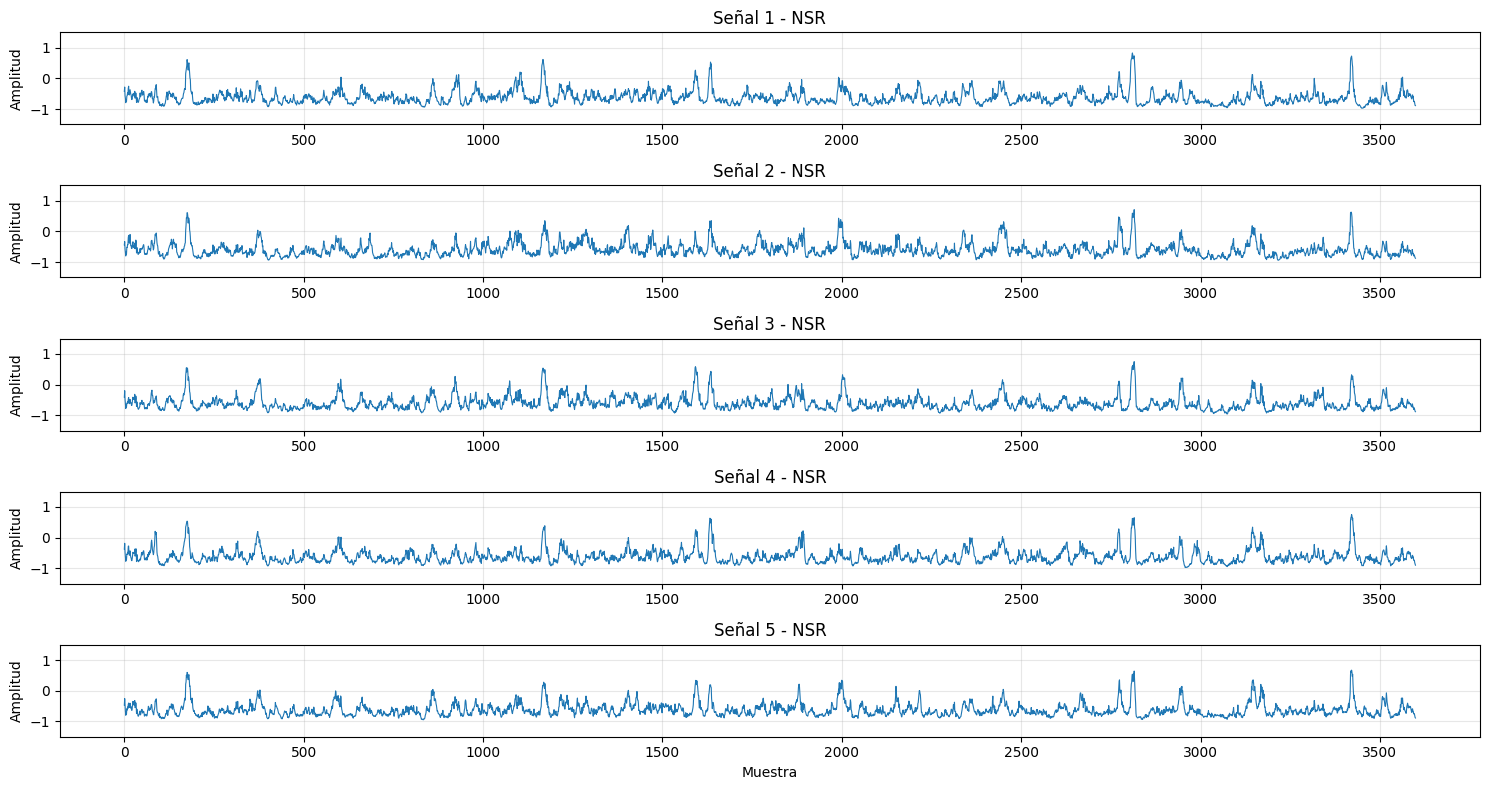

✓ Ejemplos de NSR generados y visualizados


In [23]:
# Ejemplo: Generar señales para una clase específica
def generate_ecg_for_class(generator, class_name, class_to_idx, latent_dim, 
                           num_samples=5, device='cpu'):
    """
    Genera señales ECG para una clase específica
    """
    generator.eval()
    class_idx = class_to_idx[class_name]
    
    signals = []
    with torch.no_grad():
        for _ in range(num_samples):
            z = torch.randn(1, latent_dim, device=device)
            label = torch.LongTensor([[class_idx]]).to(device)
            signal = generator(z, label).cpu().numpy().squeeze()
            signals.append(signal)
    
    return np.array(signals)

# Ejemplo de uso:
test_class = 'NSR'
test_signals = generate_ecg_for_class(
    generator, test_class, class_to_idx, latent_dim, num_samples=5, device=device
)

print(f"\nGeneradas {len(test_signals)} señales para clase '{test_class}'")
print(f"Forma de cada señal: {test_signals[0].shape}")

# Visualizar
plt.figure(figsize=(15, 8))
for i, sig in enumerate(test_signals):
    plt.subplot(5, 1, i+1)
    plt.plot(sig, linewidth=0.8)
    plt.title(f"Señal {i+1} - {test_class}")
    plt.ylabel('Amplitud')
    plt.grid(alpha=0.3)
    plt.ylim(-1.5, 1.5)
    if i == 4:
        plt.xlabel('Muestra')

plt.tight_layout()
plt.savefig(f'generated_{test_class}_examples.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Ejemplos de {test_class} generados y visualizados")

---

## 📊 Resumen del Notebook

### Estructura del Notebook:
1. **Importación de Librerías** - PyTorch, NumPy, Matplotlib
2. **Carga de Datos** - Dataset ECG con 17 clases de arritmias
3. **Preparación del Dataset** - ECGDataset personalizado con normalización
4. **Arquitectura Mejorada** - ImprovedGenerator e ImprovedDiscriminator
5. **Configuración y Entrenamiento** - Hiperparámetros y loop de entrenamiento
6. **Evaluación** - Métricas y comparación visual
7. **Guardado y Carga** - Persistencia de modelos

### Arquitectura Mejorada (ImprovedGenerator + ImprovedDiscriminator):

**Generador:**
- ConvTranspose1D progresivas (14 → 56 → 224 → 896 → 3584 → 3600)
- LSTM bidireccional para coherencia temporal
- Conexiones residuales
- Batch Normalization

**Discriminador:**
- Conv1D con Instance Normalization
- LSTM bidireccional
- Dropout para regularización

### Mejoras Implementadas:
- ✅ ConvTranspose1D para generación progresiva (mejor que repetir LSTM)
- ✅ Instance Normalization (más estable que BatchNorm en GANs)
- ✅ Feature matching loss (estadísticas de señales)
- ✅ Frequency domain loss (FFT)
- ✅ Label smoothing (0.9/0.1)
- ✅ Gradient clipping (max_norm=1.0)
- ✅ Learning rate scheduling (StepLR)
- ✅ Ratio entrenamiento D:G = 1:2

### Uso del Modelo:
```python
# Generar señales para una clase específica
signals = generate_ecg_for_class(generator, 'NSR', class_to_idx, latent_dim, num_samples=10)

# Cargar modelo guardado
loaded_gen, config = load_generator('models/generator_cgan_lstm.pth', device)
```

### Archivos Generados:
- `models/generator_cgan_lstm.pth` - Modelo del generador
- `models/discriminator_cgan_lstm.pth` - Modelo del discriminador
- `generated_samples/` - Señales generadas durante entrenamiento
- `training_metrics.png` - Gráficas de pérdidas y precisiones
- `comparison_real_vs_generated.png` - Comparación visual